In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os
from scipy.signal.windows import tukey
import json
from IPython.display import display, Math
%matplotlib notebook

# 1)

To shift an array f(x) by an arbitrary amount, we can take its FFT and multiply it by a phase ramp vector $exp(-2\pi i k m/N)$, where $m$ is the length of the shift measured in indices. Hence, when we take the inverse FFT, we get the following:

$$IFFT(exp(-2\pi i k m/N) \cdot FFT( f(x)))$$
$$ =\frac{1}{N} \sum_{x=0}^{N-1}( exp(-2\pi i k m/N)  \sum_{x=0}^{N-1} f(x) exp(-2\pi i k x/N)) exp(2\pi i k x/N)$$
$$ = \frac{1}{N} \sum_{x=0}^{N-1} \sum_{x=0}^{N-1} f(x) exp(-2\pi i k (x-m)/N) exp(2\pi i k x/N)$$

Now if we do a change of variable $x \rightarrow x-m$, this reduces to:

$$IFFT(FFT(f(x-m)) = f(x-m)$$

In [2]:
def shifting(array,shift):
    N = len(array)
    array_ft = np.fft.fft(array)
    k = np.arange(N)
    phase_ramp = np.exp(-2*np.pi*1j*k*shift/N)
    shifted = np.fft.ifft(phase_ramp*array_ft)
    return shifted

In [3]:
x = np.linspace(0,10,1001)
std = 1
cent_gauss = np.exp(-0.5*(x-np.median(x))**2/std**2)

<IPython.core.display.Javascript object>


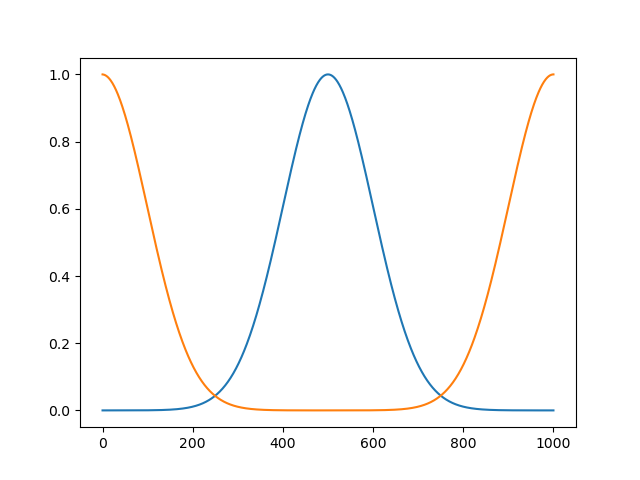

In [4]:
plt.figure()
plt.plot(np.abs(cent_gauss))
shifted_gauss = shifting(cent_gauss,len(cent_gauss)//2)
plt.plot(np.abs(shifted_gauss))

We see that the originally centered Gaussian has been shifted by half the array length, it loops back to the beginning of the array when it goes over the edge of it, due to the periodic nature of FFTS.

# 2)

## a)
To write a correlation routine is straightforward: we take the FFT of each array, multiply them together while taking the conjugate of one of them, and take the inverse FFT of that product.

In [5]:
def correlation(array1,array2):
    array1_ft, array2_ft = np.fft.fft(array1), np.fft.fft(array2)
    corr = np.fft.ifft(array1_ft*np.conj(array2_ft))
    return corr

<IPython.core.display.Javascript object>


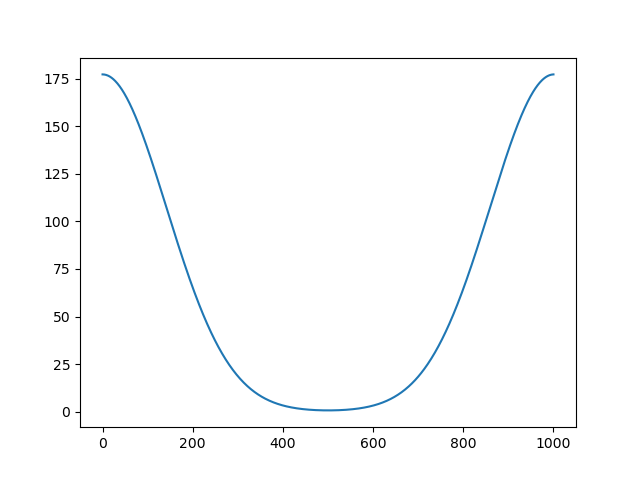

In [6]:
autocorr_gauss = correlation(cent_gauss,cent_gauss)
plt.figure()
plt.plot(np.abs(autocorr_gauss))

This result is what we expect. Taking the correlation of an array with itself starts at a maximum (when both arrays are fully overlapping, then as we "slide" the two arrays against each other, the overlap of the area between the two arrays drops down and comes back up to the maximum when we have done a "full loop" of the arrays against eachother.

## b)

We can use these two function to take the correlation of a gaussian with its shifted analog. Just take the gaussian, shift it, and correlate both of those arrays.

In [7]:
def corr_shifted_gaussian(gauss,shift):
    shifted_gauss = shifting(gauss,shift)
    corr = correlation(gauss,shifted_gauss)
    return corr

<IPython.core.display.Javascript object>


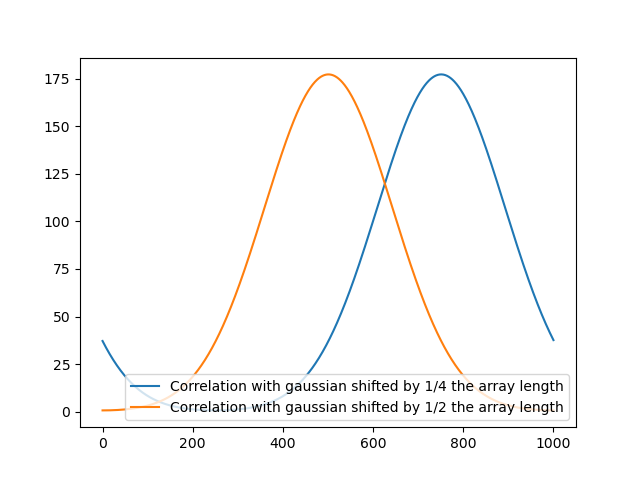

In [8]:
corr_gauss_shiftgauss_quarter = corr_shifted_gaussian(cent_gauss,len(cent_gauss)//4)
corr_gauss_shiftgauss_half = corr_shifted_gaussian(cent_gauss,len(cent_gauss)//2)
plt.figure()
plt.plot(np.abs(corr_gauss_shiftgauss_quarter), label = 'Correlation with gaussian shifted by 1/4 the array length')
plt.plot(np.abs(corr_gauss_shiftgauss_half), label = 'Correlation with gaussian shifted by 1/2 the array length')
plt.legend(loc = 'lower right')

Again, this result was expected, as the correlation of a gaussian with itself is the gaussian itself, the correlation is always the same, but it is shifted by some amount. Hence, the correlation amplitude does not depend on the shift. Only the phase does.

# 3)

To have no problems with the wrapping nature, we can pad the start of an array and the end of the other with zeros. To be certain that the non-wrapping information will be where we want it, we need to add as many zeros as there are entries in the arrays. Then, we take only the first half of the convolution. Now, when taking a convolution of a gaussian with itself, we should only see a falloff, and no rise as we don't want the information of when the arrays wrap around back into each other.

In [9]:
def convolution_nowrap(array1,array2):
    array1_w0s = np.hstack((array1,np.zeros(len(array1))))
    array2_w0s = np.hstack((np.zeros(len(array2)),array2))
    
    a1_ft,a2_ft = np.fft.fft(array1_w0s),np.fft.fft(array2_w0s)
    conv = np.fft.ifft(a1_ft*a2_ft)
    return conv[:len(conv)//2]

In [10]:
conv = convolution_nowrap(cent_gauss,cent_gauss)

<IPython.core.display.Javascript object>


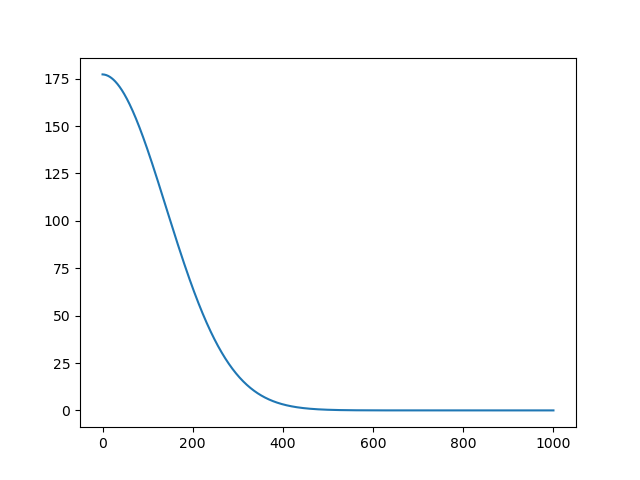

In [11]:
plt.figure()
plt.plot(np.abs(conv))

This corresponds to what we want.

# 4)


## a)

$$ \sum_{x=0}^{N-1} exp(-2 \pi i k x/N) = \sum_{x=0}^{N-1} \alpha^x $$

Where $\alpha = exp(-2 \pi i k /N)$, we can now treat this as a geometric series:

$$ s = \sum_{x=0}^{N-1} \alpha^x$$

$$ \alpha s = \sum_{x=1}^{N} \alpha^x $$

$$ s-\alpha s = \alpha^0-\alpha^N$$

$$ s = \frac{\alpha^0-\alpha^N}{1-\alpha}$$

$$ = \frac{1-exp(-2 \pi i k )}{1-exp(-2 \pi i k /N)}$$

## b)

By l'Hospital's rule:

$$ \lim_{k\to 0} \frac{1-exp(-2 \pi i k )}{1-exp(-2 \pi i k /N)} = \lim_{k\to 0} \frac{2 \pi i exp(-2 \pi i k) }{2 \pi i /N exp(-2 \pi i k /N)} = \frac{1}{1/N} = N$$

## c)

Let $f(x) = sin(x) = \frac{exp(ik_nx)-exp(-ik_nx)}{2i}$, where $k_n$ is a non-integer wave number for the sine wave.

We want to compute $$F(K) = \sum_{x=0}^{N-1} f(x) exp(-2 \pi i k x/N)$$

$$F(K) = \sum_{x=0}^{N-1} \frac{exp(ik_nx)-exp(-ik_nx)}{2i} exp(-2 \pi i k x/N)$$

$$ = \sum_{x=0}^{N-1} \frac{1}{2i} (exp(-2 \pi i k x/N+ik_nx)-exp(-2 \pi i k x/N-ik_nx))$$

$$ =  \frac{1}{2i} [\sum_{x=0}^{N-1} exp(-2 \pi i k x/N+ik_nx)-\sum_{x=0}^{N-1} exp(-2 \pi i k x/N-ik_nx))]$$

We can treat each of these sums as geometric series like in a), which yields:

$$ F(k) = \frac{1}{2i} [\frac{1-exp(i(k_nN-2\pi k))}{1-exp(i(k_n-2\pi k/N))}-\frac{1-exp(-i(k_nN-2\pi k))}{1-exp(-i(k_n-2\pi k/N))}]$$

This will be our analytic estimation of $F(k)$, Let us now compare the analytic and numerical DFTs

In [12]:
def analytic_sin_dft(wvnum,N):
    k = np.arange(N)
    term1 = (1-np.exp(1j*(wvnum*N-2*np.pi*k)))/(1-np.exp(1j*(wvnum-2*np.pi/N*k)))
    term2 = np.conj(term1)
    return 1/(2j)*(term1-term2)

In [13]:
k = 3/2
N = 10000
analytic_dft = analytic_sin_dft(k,N)
x = np.arange(N)
y = np.sin(k*x)
yft = np.fft.fft(y)

<IPython.core.display.Javascript object>


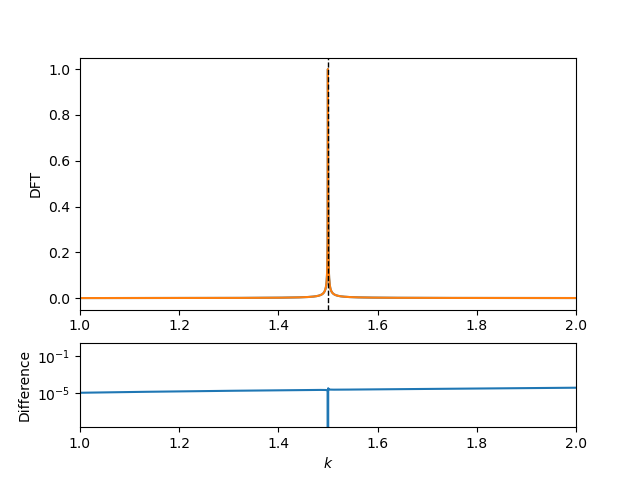

Text(0, 0.5, 'DFT')

In [14]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]})
analytic_dft_norm = np.abs(analytic_dft)/np.max(np.abs(analytic_dft))
yft_norm = np.abs(yft)/np.max(np.abs(yft))
ks = 2*np.pi/N*np.arange(N)
ax[0].plot(ks,analytic_dft_norm,label = 'Analytic')
ax[0].plot(ks,yft_norm,label = 'Numerical')
ax[0].axvline(k,linestyle = '--',linewidth = 1,color = 'k')
ax[0].set_xlim(1,2)
ax[1].semilogy(ks,np.abs(analytic_dft_norm-yft_norm))
ax[1].set_xlim(1,2)
ax[1].set_xlabel(r'$k$')
ax[1].set_ylabel('Difference')
ax[0].set_ylabel('DFT')

We see that they agree pretty well, not exactly up to machine precision, except at the peak. It also looks pretty close to a delta function, but not exactly. Note that the numerical FFT produces two spikes, corresponding to positive and negative frequencies, so I renormalized both transforms such that the highest peaks are of unity, and concentrated only on the peak of the numerical FFT that corresponds with positive frequencies.

# d)

Let us multiply the original signal by the window function $W(x) = \frac{1}{2}-\frac{1}{2}cos(2\pi x /N)$

In [15]:
def window(x):
    return 1/2-1/2*np.cos(2*np.pi*x/len(x))

<IPython.core.display.Javascript object>


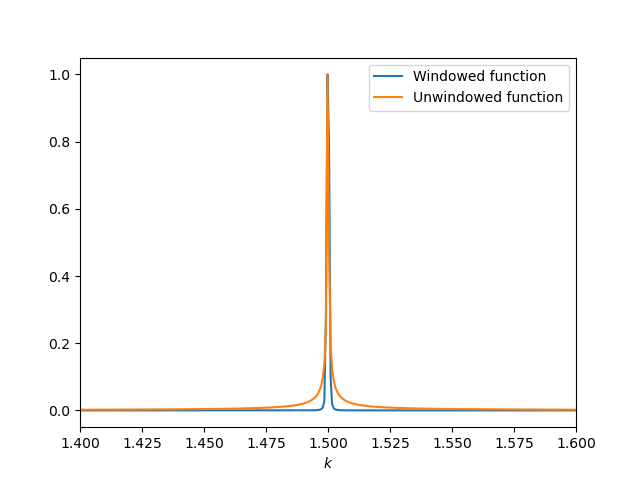

Text(0.5, 0, '$k$')

In [16]:
win = window(x)
y_win = win*y
y_winft = np.fft.fft(np.fft.fftshift(y_win))
plt.figure()
y_winft_norm = np.abs(y_winft)/np.max(np.abs(y_winft))
plt.plot(ks,y_winft_norm,label = 'Windowed function')
plt.plot(ks,yft_norm,label = "Unwindowed function")
plt.legend()
plt.xlim(1.4,1.6)
plt.xlabel(r'$k$')

We see that the width of the peak is much smaller with the windowed function: the leakage has dropped.

# e)

We can show what is the transform of the window:

<IPython.core.display.Javascript object>


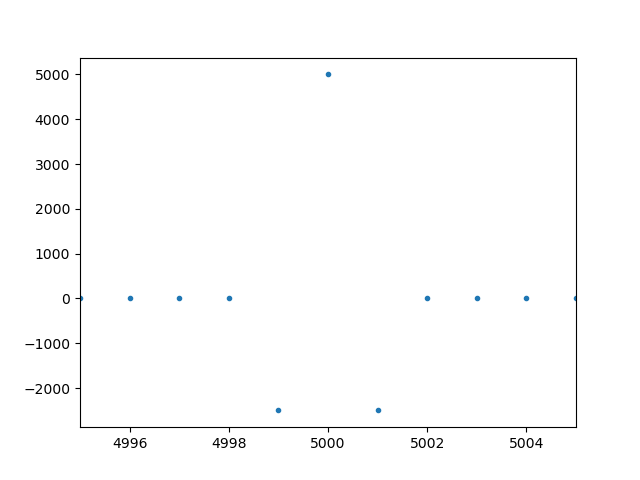

C:\Users\miara\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(4995.0, 5005.0)

In [17]:
winft = np.fft.fft(win)
plt.figure()
plt.plot(np.fft.fftshift(winft),'.')
plt.xlim(4995,5005)

In [18]:
display(Math('$ F(0) = {}$'.format(np.abs(winft[0]))))
display(Math('$ F(1) = {}$'.format(np.abs(winft[1]))))
display(Math('$ F(N) = {}$'.format(np.abs(winft[-1]))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We had 10000 points in our window, and the only non-zero modes in the FFT of the window are indeed F(0),F(1), and F(N), which are N/2,N/4 and N/4 respectively.

<IPython.core.display.Javascript object>


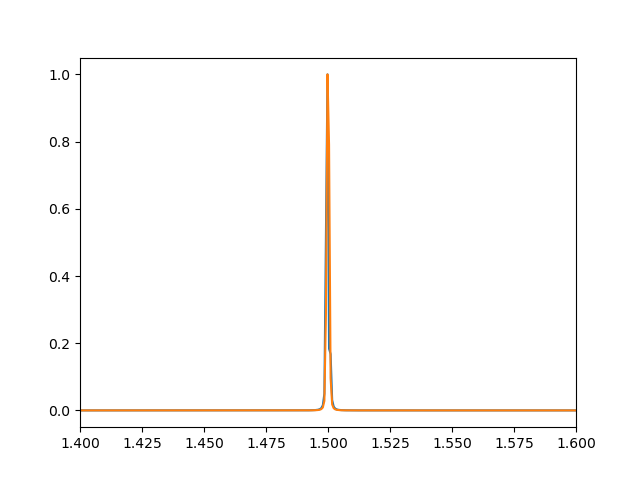

(1.4, 1.6)

In [19]:
def moving_avg(array):
    averaged = array.copy()
    for i in range(len(array)-1):
        averaged[i] = -array[i-1]/4-array[i+1]/4+array[i]/2
    averaged[-1] =  -array[-2]/4-array[0]/4+array[-1]/2
    return averaged

win_equiv = np.abs(moving_avg(yft_norm))
plt.figure()
win_equiv_norm = win_equiv/np.max(win_equiv)
plt.plot(ks,win_equiv_norm)
plt.plot(ks,y_winft_norm)
plt.xlim(1.4,1.6)

# 5)

In [20]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    tp=template[0]
    tx=template[1]
    return tp,tx
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [21]:
path = 'Ligo_data/'
fnames_L_unordered=glob.glob(path+"L-*.hdf5")
fnames_H_unordered=glob.glob(path+"H-*.hdf5")
fnames_H = [0]*len(fnames_H_unordered)
fnames_L = [0]*len(fnames_L_unordered)
fnames_H[0] = fnames_H_unordered[1]
fnames_L[0] = fnames_L_unordered[1]
fnames_H[1] = fnames_H_unordered[3]
fnames_L[1] = fnames_L_unordered[3]
fnames_H[2] = fnames_H_unordered[0]
fnames_L[2] = fnames_L_unordered[0]
fnames_H[3] = fnames_H_unordered[2]
fnames_L[3] = fnames_L_unordered[2]

L_events = []
for fname in fnames_L:
    L_events.append(read_file(fname))
    

H_events = []
for fname in fnames_H:
    H_events.append(read_file(fname))

<IPython.core.display.Javascript object>


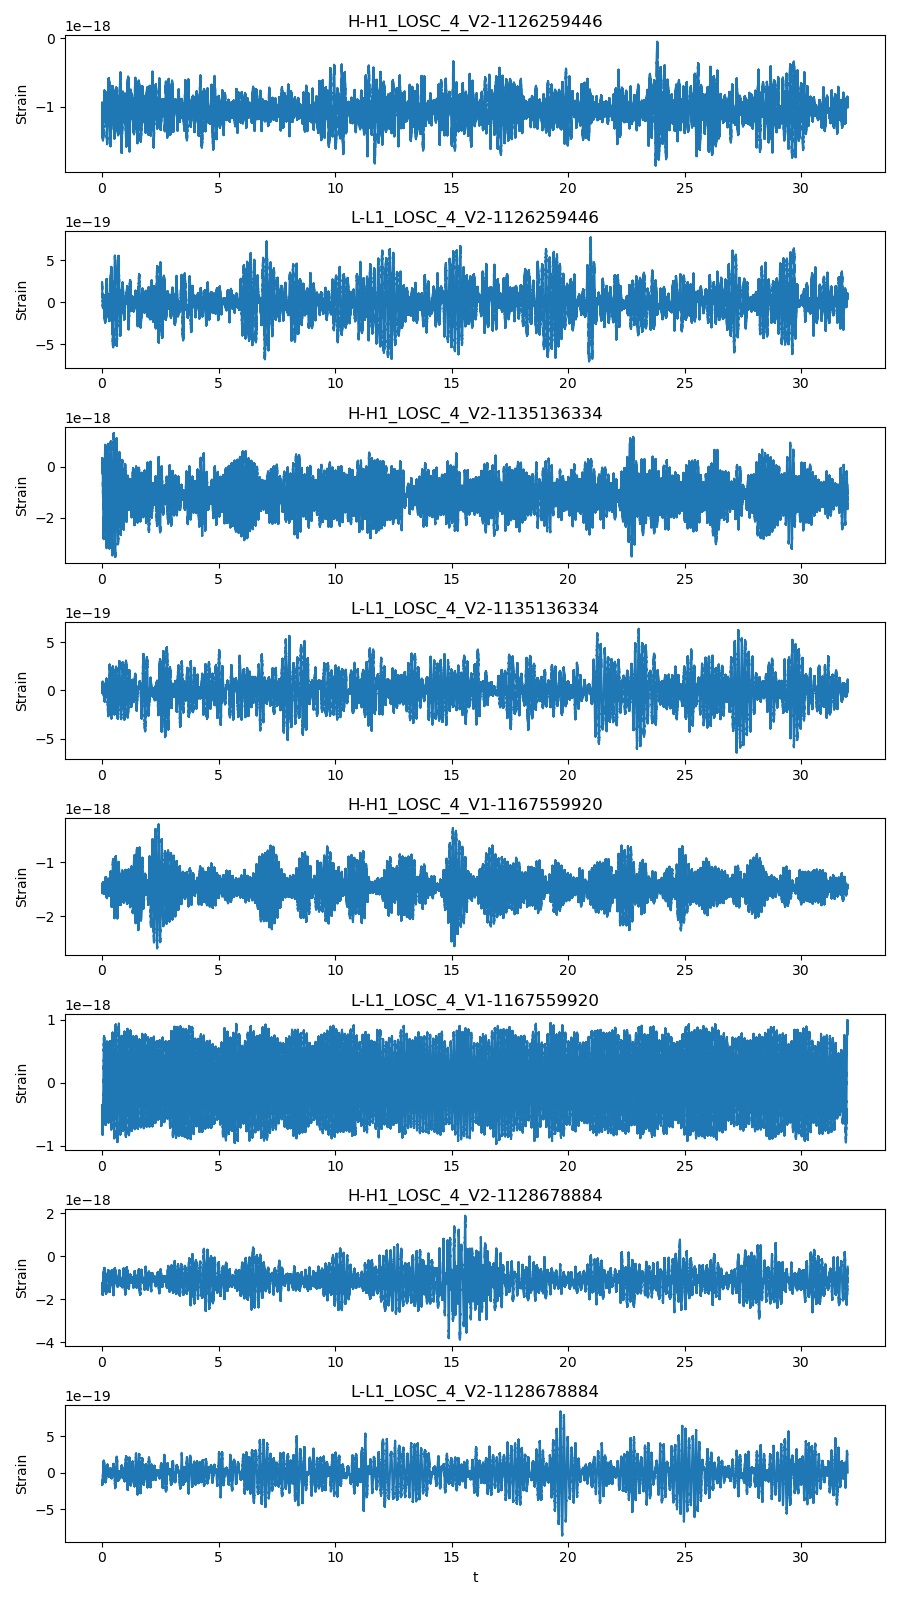

In [22]:
fig, ax = plt.subplots(len(L_events)+len(H_events),1,figsize = (9,len(H_events)*4))

for i in range(len(L_events)):
    strain,dt,utc = L_events[i]
    t = np.arange(len(strain))*dt
    ax[2*i].plot(t,strain)
    ax[2*i].set_ylabel('Strain')
    ax[2*i].set_title(fnames_H[i][10:-8])
for i in range(len(H_events)):
    strain,dt,utc = H_events[i]
    t = np.arange(len(strain))*dt
    ax[2*i+1].plot(t,strain)
    ax[2*i+1].set_ylabel('Strain')
    ax[2*i+1].set_title(fnames_L[i][10:-8])
ax[-1].set_xlabel('t')
    
fig.tight_layout()

In [23]:
fnames=glob.glob(path+"*template.hdf5")
templates = []
for fname in fnames:
    templates.append(read_template(fname))

<IPython.core.display.Javascript object>


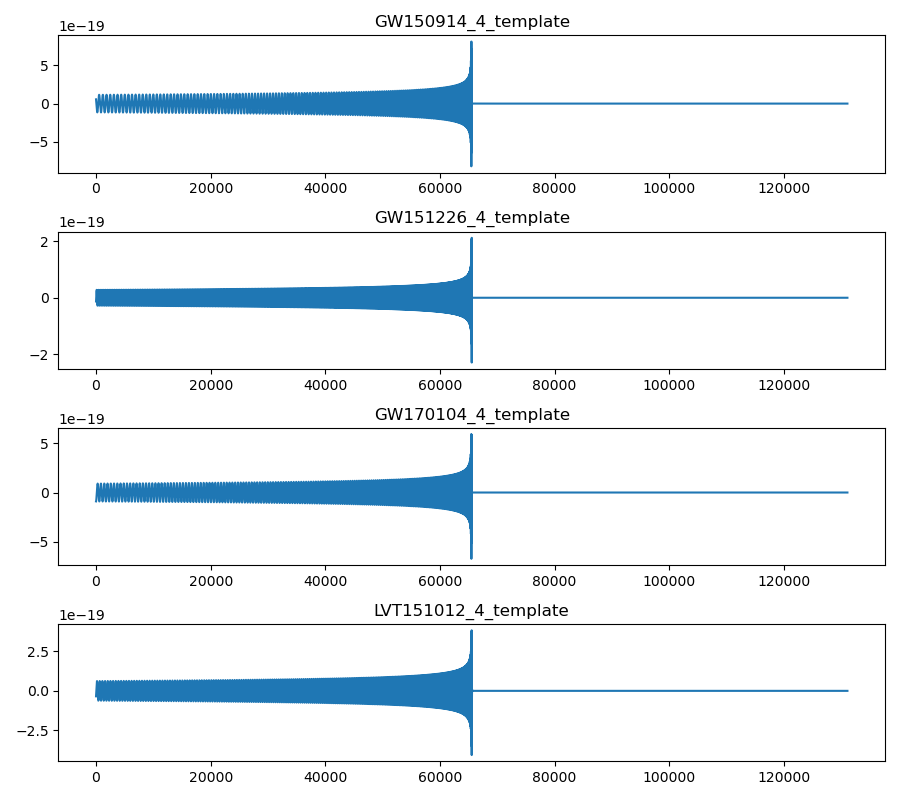

In [24]:
fig, ax = plt.subplots(len(templates),1,figsize = (9,len(templates)*2))

for i in range(len(templates)):
    tp,tx = templates[i]
    ax[i].plot(tp)
    ax[i].set_title(fnames[i][10:-5])
    
fig.tight_layout()

## a)

In [91]:
H_noises = []

for i in range(len(H_events)):
    win = tukey(len(H_events[i][0]))
    noise = np.abs(np.fft.rfft(win*H_events[i][0]))
    H_noises.append(np.abs(noise)**2)
H_noise = np.mean(H_noises, axis = 0)

L_noises = []

for i in range(len(L_events)):
    win = tukey(len(L_events[i][0]))
    noise = np.abs(np.fft.rfft(win*L_events[i][0]))
    L_noises.append(np.abs(noise)**2)
L_noise = np.mean(L_noises, axis = 0)

<IPython.core.display.Javascript object>


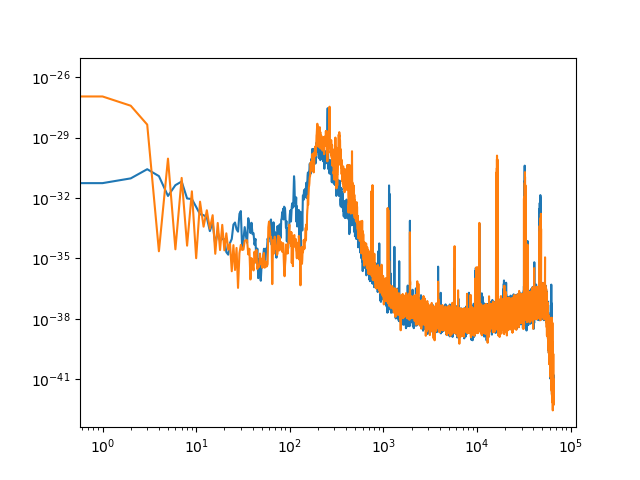

In [92]:
plt.figure()
plt.loglog(H_noise)
plt.loglog(L_noise)

In [101]:
def smooth_vector(vec,sig):
    n=len(vec)
    x=np.arange(n)
    x[n//2:]=x[n//2:]-n
    kernel=np.exp(-0.5*x**2/sig**2) #make a Gaussian kernel
    kernel=kernel/kernel.sum()
    vecft=np.fft.rfft(vec)
    kernelft=np.fft.rfft(kernel)
    vec_smooth=np.fft.irfft(vecft*kernelft) #convolve the data with the kernel
    return vec_smooth

In [102]:
H_noise_smooth = smooth_vector(H_noise,3)
L_noise_smooth = smooth_vector(L_noise,3)

tobs=dt*len(strain)
dnu=1/tobs
nu=np.arange(len(H_noise_smooth))*dnu
nu[0]=0.5*nu[1]


<IPython.core.display.Javascript object>


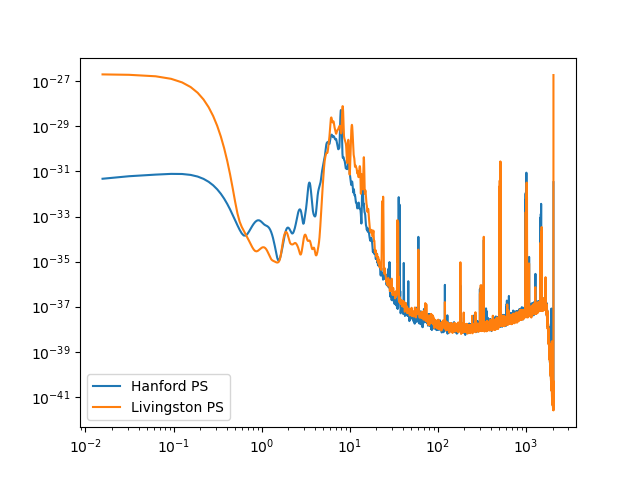

In [103]:
plt.figure()
plt.loglog(nu,np.abs(H_noise_smooth),label = 'Hanford PS')
plt.loglog(nu,np.abs(L_noise_smooth),label = 'Livingston PS')
plt.legend()

In [104]:
Ninv_L,Ninv_H = 1/L_noise_smooth,1/H_noise_smooth
Ninv_L[nu>1500],Ninv_H[nu>1500]=0,0
Ninv_L[nu<20],Ninv_H[nu<20]=0,0

## b)-c)

<IPython.core.display.Javascript object>


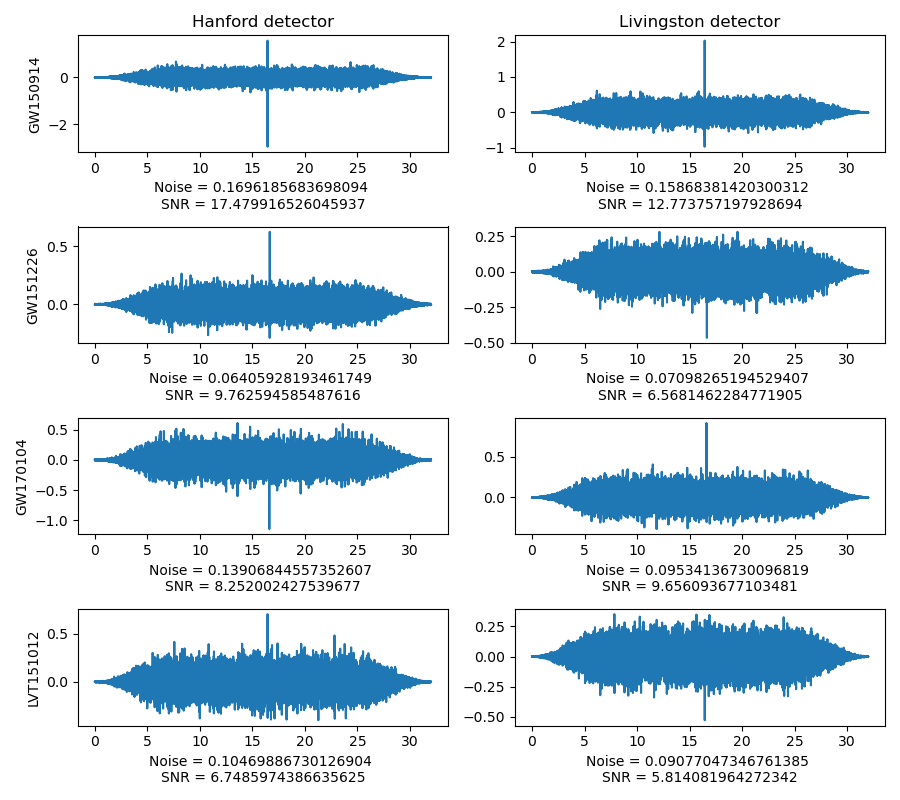

In [156]:
fig,ax = plt.subplots(len(L_events),2,figsize = (9,8))

comb_SNRs = np.zeros(len(H_events))
opt_SNRs = np.zeros(len(H_events))


for i in range(len(H_events)):
    ax[i][0].set_ylabel(fnames[i][10:-16]) 
    
    H_strain = H_events[i][0]
    L_strain = L_events[i][0]
    
    t = H_events[i][1]*np.arange(len(H_strain))
    
    H_strainft = np.fft.rfft(win*H_strain)
    L_strainft = np.fft.rfft(win*L_strain)
    
    tp = templates[i][0]
    tpft = np.fft.rfft(tp*win)
    H_tp_filtered = tpft[:-1]*Ninv_H
    L_tp_filtered = tpft[:-1]*Ninv_L
    
    H_mf = np.fft.fftshift(np.fft.irfft(np.conj(H_tp_filtered)*H_strainft[:-1]))
    L_mf = np.fft.fftshift(np.fft.irfft(np.conj(L_tp_filtered)*L_strainft[:-1]))
    
    ax[i][0].plot(t[:-2],H_mf)
    ax[i][1].plot(t[:-2],L_mf)
    
    H_noise_est = np.std(H_mf[len(H_mf)//4:-len(H_mf)//4])
    L_noise_est = np.std(L_mf[len(L_mf)//4:-len(L_mf)//4])
    
    H_SNR = np.max(np.abs(H_mf))/H_noise_est
    L_SNR = np.max(np.abs(L_mf))/L_noise_est
    
    ax[i][0].set_xlabel('Noise = {} \nSNR = {}'.format(H_noise_est,H_SNR))
    ax[i][1].set_xlabel('Noise = {} \nSNR = {}'.format(L_noise_est,L_SNR))
    
    comb_SNRs[i] = (H_SNR+L_SNR)/2
    TP_adj = tp[::2]
    opt_SNRs_H = np.sqrt(TP_adj.T@(Ninv_H*TP_adj))
    opt_SNRs_L = np.sqrt(TP_adj.T@(Ninv_L*TP_adj))
    opt_SNRs[i] = 0.5*(opt_SNRs_H+opt_SNRs_L)
       
    
    
ax[0][0].set_title('Hanford detector')
ax[0][1].set_title('Livingston detector')
fig.tight_layout()    

## d)

In [157]:
for i in range(len(comb_SNRs)):
    print('Event {}:\n'.format(fnames[i][10:-16]))
    print('combined SNR =  {}'.format(comb_SNRs[i]))
    print('optimal SNR =  {}'.format(opt_SNRs[i]))
    print('\n')
    

Event GW150914:

combined SNR =  15.126836861987314
optimal SNR =  118.35701693789593


Event GW151226:

combined SNR =  8.165370406982403
optimal SNR =  28.827742401265024


Event GW170104:

combined SNR =  8.954048052321578
optimal SNR =  93.52416766099896


Event LVT151012:

combined SNR =  6.281339701467952
optimal SNR =  63.850368099161045




<IPython.core.display.Javascript object>


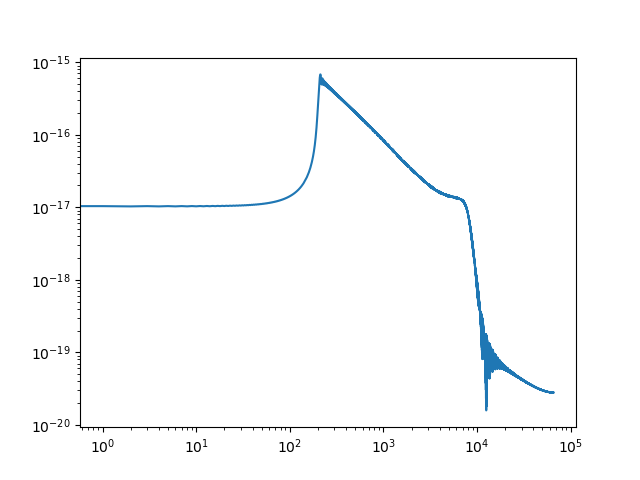

3.926880395840047e-20


<IPython.core.display.Javascript object>


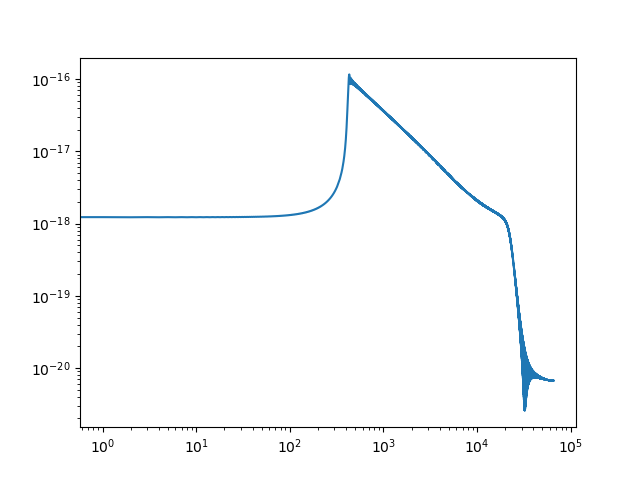

1.1976418479384412e-20


<IPython.core.display.Javascript object>


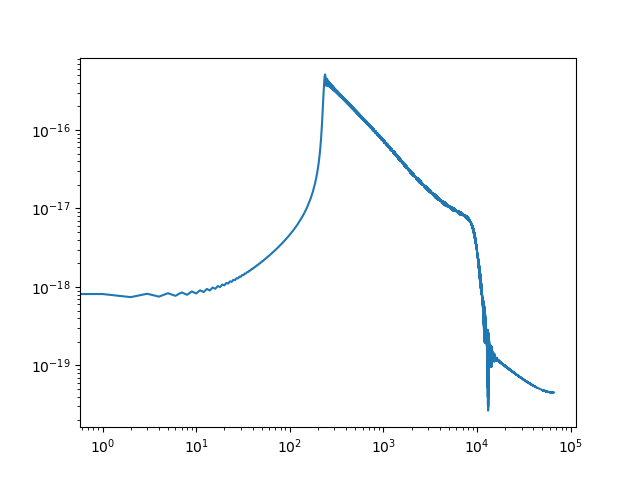

6.355005198317138e-20


<IPython.core.display.Javascript object>


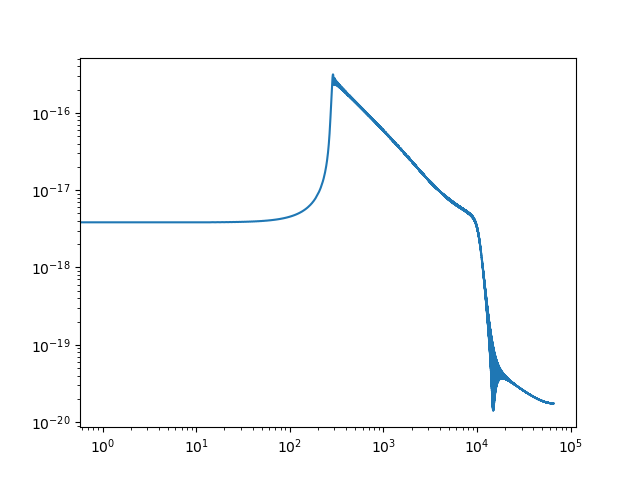

2.4345524756151112e-20


In [202]:
for i in range(len(templates)):
    f = np.fft.fftfreq(len(templates[i][0]))
    plt.figure()
    P = np.abs(np.fft.rfft(templates[i][0]))[:-1]
    plt.loglog(P)
    print(np.median(P))



2
